2023-10-21 12:19:42.818968: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100)              20800     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
110/110 [==============================] - 2s 5ms/step - loss: 0.0096 - val_loss: 0.0248
Epoch 2/50
110/110 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0240
Epoch 3/50
110/110 [==============================] - 0s 3ms/step - loss: 0.0047 - val_loss: 0.0245
Epoch 4/50
110/110 [==============================] - 0s 3ms/step - loss: 0.0

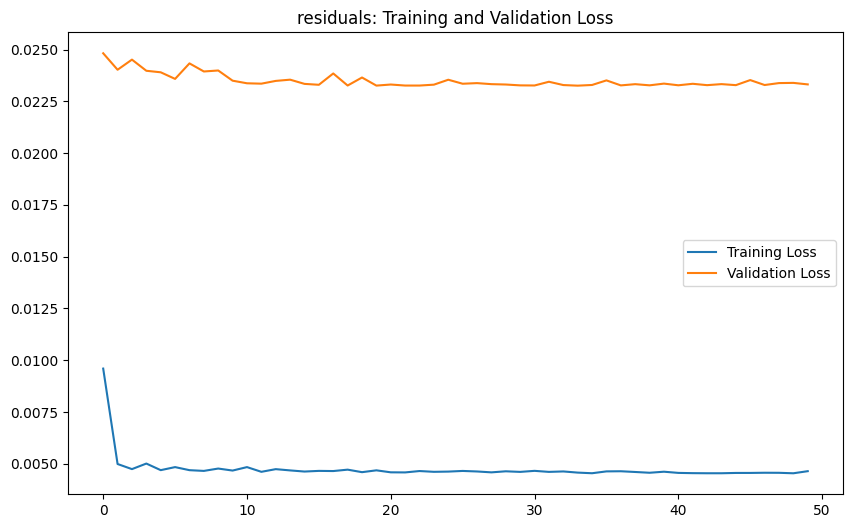

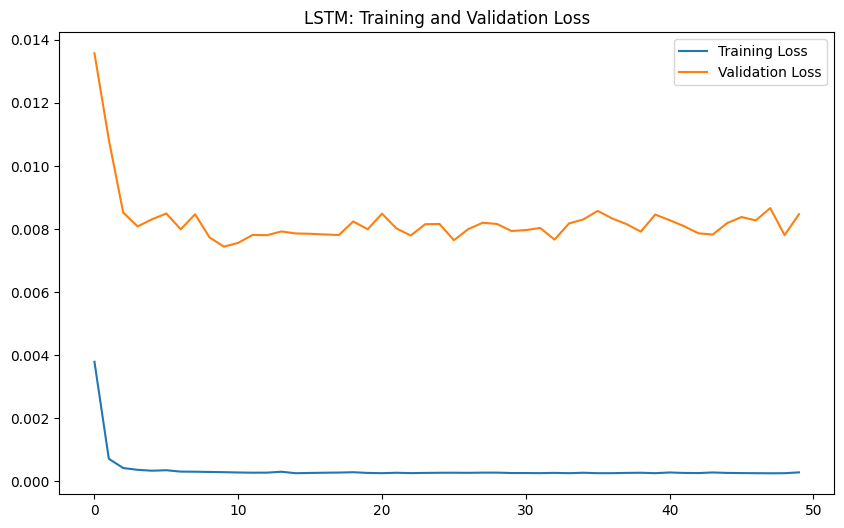

6/6 [==============================] - 0s 1ms/step


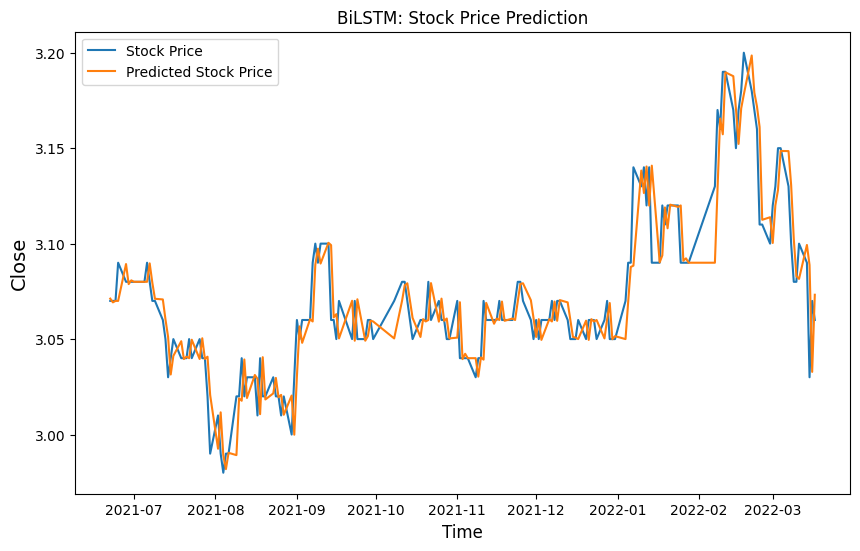

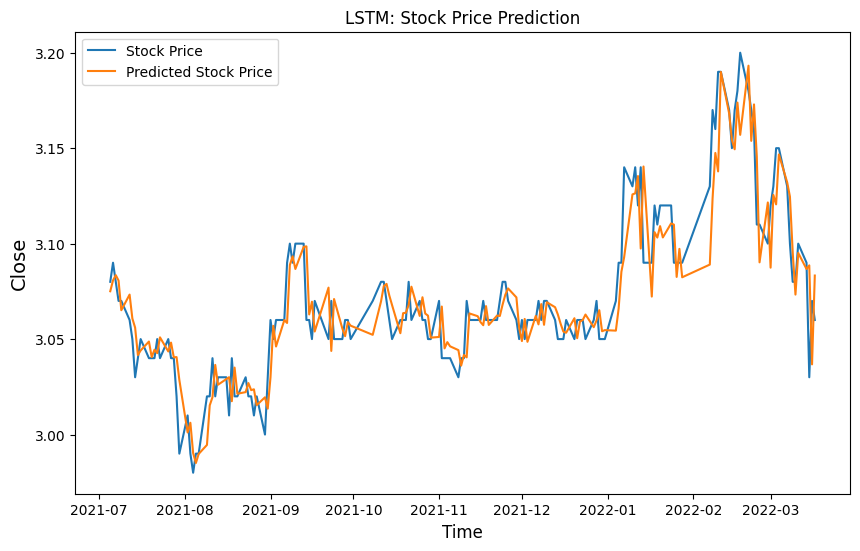

MSE: 0.00027
RMSE: 0.01650
MAE: 0.01197
R2: 0.84235


In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.optimizers import Adam
# from tensorflow.keras.optimizers import Adam
from numpy.random import seed
from utils import *
from model import lstm

# GPU
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.set_visible_devices([gpus[0]], "GPU")

seed(1)
tf.random.set_seed(1)

n_timestamp = 10
n_epochs = 50
# ====================================
#      model type：
#            1. single-layer LSTM
#            2. multi-layer LSTM
#            3. bidirectional LSTM
# ====================================
model_type = 3

yuan_data = pd.read_csv('./601988.SH.csv')  
yuan_data.index = pd.to_datetime(yuan_data['trade_date'], format='%Y%m%d') 
yuan_data = yuan_data.loc[:, ['open', 'high', 'low', 'close', 'amount']]

data = pd.read_csv('./ARIMA_residuals1.csv')
data.index = pd.to_datetime(data['trade_date'])
data = data.drop('trade_date', axis=1)
# data = pd.merge(data, yuan_data, on='trade_date') 

Lt = pd.read_csv('./ARIMA.csv')
idx = 3500
training_set = data.iloc[1:idx, :]
test_set = data.iloc[idx:, :]
yuan_training_set = yuan_data.iloc[1:idx, :]
yuan_test_set = yuan_data.iloc[idx:, :]

sc = MinMaxScaler(feature_range=(0, 1))
yuan_sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.fit_transform(test_set)
yuan_training_set_scaled = yuan_sc.fit_transform(yuan_training_set)
yuan_testing_set_scaled = yuan_sc.fit_transform(yuan_test_set)

X_train, y_train = data_split(training_set_scaled, n_timestamp)
yuan_X_train, yuan_y_train = data_split(yuan_training_set_scaled, n_timestamp)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
yuan_X_train = yuan_X_train.reshape(yuan_X_train.shape[0], yuan_X_train.shape[1], 5)

X_test, y_test = data_split(testing_set_scaled, n_timestamp)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
yuan_X_test, yuan_y_test = data_split(yuan_testing_set_scaled, n_timestamp)
yuna_X_test = yuan_X_test.reshape(yuan_X_test.shape[0], yuan_X_test.shape[1], 5)

model, yuan_model = lstm(model_type,X_train,yuan_X_train)
print(model.summary())
adam = Adam(learning_rate=0.01)
model.compile(optimizer=adam,
              loss='mse')
yuan_model.compile(optimizer=adam,
                   loss='mse')

history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=n_epochs,
                    validation_data=(X_test, y_test),
                    validation_freq=1)
yuan_history = yuan_model.fit(yuan_X_train, yuan_y_train,
                              batch_size=32,
                              epochs=n_epochs,
                              validation_data=(yuan_X_test, yuan_y_test),
                              validation_freq=1)


plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('residuals: Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(yuan_history.history['loss'], label='Training Loss')
plt.plot(yuan_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM: Training and Validation Loss')
plt.legend()
plt.show()

yuan_predicted_stock_price = yuan_model.predict(yuan_X_test)
yuan_predicted_stock_price = yuan_sc.inverse_transform(yuan_predicted_stock_price)
yuan_predicted_stock_price_list = np.array(yuan_predicted_stock_price[:, 3]).flatten().tolist()
yuan_predicted_stock_price1 = {
    'trade_date': yuan_data.index[idx+10:],
    'close': yuan_predicted_stock_price_list
}
yuan_predicted_stock_price1 = pd.DataFrame(yuan_predicted_stock_price1)
yuan_predicted_stock_price1 = yuan_predicted_stock_price1.set_index(['trade_date'], drop=True)
yuan_real_stock_price = yuan_sc.inverse_transform(yuan_y_test)
yuan_real_stock_price_list = np.array(yuan_real_stock_price[:, 3]).flatten().tolist()
yuan_real_stock_price1 = {
    'trade_date': yuan_data.index[idx+10:],
    'close': yuan_real_stock_price_list
}
yuan_real_stock_price1 = pd.DataFrame(yuan_real_stock_price1)
yuan_real_stock_price1 = yuan_real_stock_price1.set_index(['trade_date'], drop=True)

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price_list = np.array(predicted_stock_price[:, 0]).flatten().tolist()

predicted_stock_price1 = {
    'trade_date': data.index[idx+10:],
    'close': predicted_stock_price_list
}
predicted_stock_price1 = pd.DataFrame(predicted_stock_price1)

predicted_stock_price1 = predicted_stock_price1.set_index(['trade_date'], drop=True)

real_stock_price = sc.inverse_transform(y_test)
finalpredicted_stock_price = pd.concat([Lt, predicted_stock_price1]).groupby('trade_date')['close'].sum().reset_index()
finalpredicted_stock_price.index = pd.to_datetime(finalpredicted_stock_price['trade_date']) # 将时间格式改变一下
finalpredicted_stock_price = finalpredicted_stock_price.drop(['trade_date'], axis=1)

plt.figure(figsize=(10, 6))
# print('yuan_real', yuan_real_stock_price1)
plt.plot(yuan_data.loc['2021-06-22':, 'close'], label='Stock Price')
plt.plot(finalpredicted_stock_price['close'], label='Predicted Stock Price')
plt.title('BiLSTM: Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(yuan_real_stock_price1['close'], label='Stock Price')
plt.plot(yuan_predicted_stock_price1['close'], label='Predicted Stock Price')
plt.title('LSTM: Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

yhat = yuan_data.loc['2021-06-22':, 'close']
evaluation_metric(finalpredicted_stock_price['close'],yhat)